In [1]:
import matplotlib.pyplot as plt
from astropy.coordinates import ICRS, Galactic, GalacticLSR, Galactocentric
import astropy.units as u
import astropy.coordinates as apycoords
import pandas as pd
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib.figure import figaspect
import statistics as stat
import numpy as np
import scipy
from scipy import stats
from astropy.coordinates import SkyCoord
from astropy.coordinates import SkyCoord
from numpy.polynomial import Polynomial
import numpy as np

# Trace the Stars and clusters along the Radcliffe Wave

In [2]:
def trace_stars_along_wave(stars_file, wave_file, radius):
    """
    Traces stars along the Radcliffe wave in 3D position space using NumPy vectorization for efficiency.
    
    Parameters:
    - stars_file (str): Path to the CSV file containing star data.
    - wave_file (str): Path to the CSV file containing best-fit Radcliffe wave data.
    - radius (float): Maximum distance for stars to be considered part of the wave.
    
    Returns:
    - pd.DataFrame: DataFrame of traced stars.
    """
    # Load wave and stars data
    wave_df = pd.read_csv(wave_file)
    stars_df = pd.read_csv(stars_file)

    # Extract coordinates
    a, b_c, c = wave_df[['x', 'y', 'z']].values.T  # Wave coordinates in pc
    x, y, z = stars_df[['X', 'Y', 'Z']].values.T * 1000  # Star coordinates (convert from kpc to pc)

    # Compute distances using broadcasting (efficient vectorized calculation)
    distances = np.sqrt((x[:, None] - a[None, :])**2 + 
                        (y[:, None] - b_c[None, :])**2 + 
                        (z[:, None] - c[None, :])**2)

    # Find the minimum distance for each star
    min_distances = np.min(distances, axis=1)

    # Filter stars within the given radius
    mask = min_distances <= radius
    traced_df = stars_df.loc[mask].copy()  # Copy ensures original DataFrame is not modified

    return traced_df


# Compute the Moving median of the vertical velocities and the bootstrap errors of the Moving median

In [3]:
import numpy as np
import pandas as pd

def compute_moving_median_and_bootstrap(traced_df, n_bootstrap, output_file):
    """
    Computes the moving median and bootstrap errors of Vzprime along the wave.
    
    Parameters:
    - traced_df (pd.DataFrame): DataFrame of traced stars.
    - n_bootstrap (int): Number of bootstrap resamples.
    - output_file (str): Name of the output CSV file.
    
    Returns:
    - pd.DataFrame: DataFrame containing moving medians and bootstrap errors.
    """
    # Define the bin edges for moving median calculation
    bins = np.linspace(-1100, 1800, 21)  # Standard bins
    
    y, vz = traced_df.Y.values*1000, traced_df.Vzprime.values

    # Initialize lists to store results
    median_vz, bin_center, error_med = [], [], []

    # Loop over each bin (ignoring the first and last bins)
    for i in range(1, len(bins) - 1):
        vz_array = []

        # Collect Vzprime values within the current bin range
        for j in range(len(y)):
            if bins[i-1] <= y[j] <= bins[i+1]:
                vz_array.append(vz[j])

        if vz_array:  # Ensure there are values in the current bin
            # Compute the median of Vzprime for the current bin
            median_vz.append(np.median(vz_array))
            # Compute the midpoint of the bin as the median y value
            bin_center.append(np.mean([bins[i-1], bins[i+1]]))

            # Perform bootstrap resampling to calculate error
            bootstrap_samples = [np.median(np.random.choice(vz_array, len(vz_array), replace=True)) 
                                 for _ in range(n_bootstrap)]
            error_med.append(np.std(bootstrap_samples))
        else:
            # If no data points in the bin, append NaN
            median_vz.append(np.nan)
            bin_center.append(np.nan)
            error_med.append(np.nan)

    # Create DataFrame with the results
    output_df = pd.DataFrame({
        'median_y': bin_center,
        'median_vz': median_vz,
        'err': error_med
    })

    # Save the results to a CSV file
    output_df.to_csv(output_file, index=False)
    
    return output_df


# UMS stars along Radcliffe wave

In [4]:
wave_file='Best_Fit_Wave_Model.csv'
stars_file='Cleaned_Data/UMS_Stars_cleaned.csv'
radius=80 # 80 pc is our selection critera (See the paper for explanation)
traced_ums=trace_stars_along_wave(stars_file, wave_file, radius)

In [5]:
traced_ums

,source_id,l,b,distance,X,Y,Z,Vzprime,R,pm_b,pm_l
155010,2943980183382999296,225.487281,-13.327194,0.693500,-0.473097,-0.481213,-0.159860,5.648021,8.608557,0.961424,-1.236130
156748,2992282278942457088,221.976952,-17.306561,0.760526,-0.539789,-0.485635,-0.226245,7.042661,8.675392,1.750170,0.643987
156842,2948578100492596352,226.356292,-4.979711,0.994025,-0.683458,-0.716606,-0.086284,2.194980,8.834569,-0.684132,-0.916386
157061,2948379707364922496,227.235589,-3.236315,1.046227,-0.709240,-0.766864,-0.059064,5.730783,8.864472,-0.098047,-1.684890
157229,2950666828987317760,224.457365,-8.758300,0.926533,-0.653622,-0.641357,-0.141080,8.908863,8.799027,1.157680,-2.730250
...,...,...,...,...,...,...,...,...,...,...,...
485564,3400093753027636480,187.101208,-3.336665,0.296366,-0.293594,-0.036575,-0.017249,3.980927,8.415673,-2.097860,7.359530
485764,3317210608020322048,204.933203,-8.008941,0.344228,-0.309101,-0.143698,-0.047960,-7.207859,8.432326,-7.577760,-0.215721
485765,3316981497284267136,205.615867,-7.772416,0.350681,-0.313309,-0.150219,-0.047426,1.070631,8.436646,-2.541080,-1.294850
485828,540153645701985152,120.926799,13.533295,0.279934,-0.139875,0.233467,0.065508,-4.887868,8.265173,-8.975050,18.451600


In [6]:
# coordinates of stars along Radcliffe Wave
x=traced_ums.X.values*1000
y=traced_ums.Y.values*1000
z=traced_ums.Z.values*1000

In [7]:
# Best fit to the Radcliffe wave taken from Alves et al. 2020
wave_df = pd.read_csv(wave_file)
a=wave_df.x.values
b_c=wave_df.y.values
c=wave_df.z.values

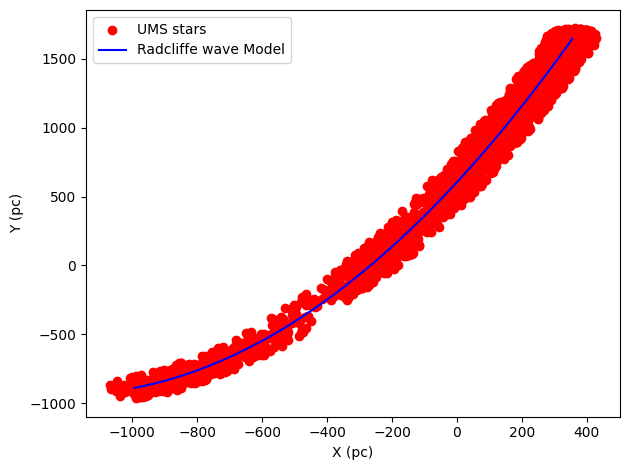

In [8]:
# Make sure our code traced the stars correctly
plt.scatter(x,y,c='r',label='UMS stars')
plt.plot(a,b_c,c='b',label='Radcliffe wave Model')
plt.legend()
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.show()

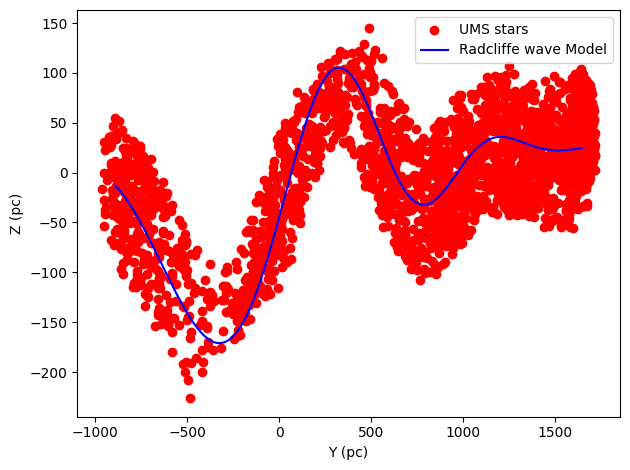

In [9]:
# Make sure our code traced the stars correctly
plt.scatter(y,z,c='r',label='UMS stars')
plt.plot(b_c,c,c='b',label='Radcliffe wave Model')
plt.legend()
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.show()

In [10]:
# Output is saved to the directory
n_bootstrap=1500
output_file='Stars_along_Radcliffe_Wave/UMS_traced_radcliffewave_median.csv'
medianvz_df=compute_moving_median_and_bootstrap(traced_ums, n_bootstrap, output_file)


In [11]:
medianvz_df

,median_y,median_vz,err
0,-955.0,-1.180929,1.044648
1,-810.0,-0.898851,0.781443
2,-665.0,-0.410088,0.756530
3,-520.0,-1.697550,0.734568
4,-375.0,-2.777165,0.775170
5,-230.0,2.779070,0.465237
6,-85.0,1.853949,0.333312
7,60.0,0.081027,0.461217
8,205.0,0.452861,0.517393
9,350.0,0.965198,0.556439


# OB stars along Radcliffe wave

In [12]:
# trace the stars along Radcliffe wave
wave_file='Best_Fit_Wave_Model.csv'
stars_file='Cleaned_Data/OB_Stars_cleaned.csv'
radius=80 # 80 pc is our selection critera (See the paper for explanation)
traced_ob=trace_stars_along_wave(stars_file, wave_file, radius)

In [13]:
traced_ob

,source_id,l,b,distance,X,Y,Z,Vzprime,R,pm_b,pm_l
20,3001108264938556800,220.17052,-11.93837,0.6117,-0.457307,-0.386051,-0.126536,-2.971161,8.806137,-1.411430,-1.363565
39,2949637033271640448,224.97612,-5.44105,1.0720,-0.754917,-0.754288,-0.101649,-0.273833,9.126423,-0.808395,0.271520
48,3049168983344995584,223.22472,-3.65938,1.2991,-0.944689,-0.887890,-0.082915,0.212524,9.327266,-0.742734,0.053356
67,3045838837503121280,224.68481,-2.34384,1.0838,-0.769922,-0.761497,-0.044323,-12.315410,9.141789,-3.520104,-3.337766
70,3045713939855362944,225.47060,-2.57138,1.0572,-0.740642,-0.752909,-0.047430,-9.140604,9.111908,-2.948970,-2.753815
...,...,...,...,...,...,...,...,...,...,...,...
12239,2067518164478235648,78.14556,1.82196,1.6910,0.347200,1.654099,0.053763,9.213802,8.161950,0.302883,-6.791086
12276,2061130345520591488,76.85208,0.61275,1.7084,0.388580,1.663521,0.018270,3.179781,8.123469,-0.484592,-6.823894
12277,2061117525036716032,76.84629,0.54541,1.6489,0.375214,1.605565,0.015696,3.679012,8.124910,-0.440209,-6.723746
12323,3346200365957845120,194.50438,-8.00967,0.3506,-0.336115,-0.086953,-0.048853,-9.339140,8.676663,-8.403851,5.737026


In [14]:
# Calculate the median vertical velocities of the stars along the Radcliffe Wave
# Output is saved to the directory
n_bootstrap=1500
output_file='Stars_along_Radcliffe_Wave/OB_traced_radcliffewave_median.csv'
medianvz_df=compute_moving_median_and_bootstrap(traced_ob, n_bootstrap, output_file)


In [15]:
medianvz_df

,median_y,median_vz,err
0,-955.0,-11.178521,4.010043
1,-810.0,-7.031076,2.451347
2,-665.0,-5.387213,2.194439
3,-520.0,-3.536366,2.171619
4,-375.0,-3.859697,2.387183
5,-230.0,1.923938,0.273225
6,-85.0,1.926563,0.290991
7,60.0,0.205859,0.975157
8,205.0,-0.239848,0.721394
9,350.0,0.406872,2.405932


# Open Clusters along Radcliffe wave

In [16]:
# trace the stars along Radcliffe wave
wave_file='Best_Fit_Wave_Model.csv'
stars_file='Cleaned_Data/Open_Clusters_cleaned.csv'
radius=160 # 160 pc is our selection critera (See the paper for explanation)
traced_oc=trace_stars_along_wave(stars_file, wave_file, radius)

In [17]:
traced_oc

,source_id,l,b,distance,X,Y,Z,Vzprime,R,pm_b,pm_l
4,ASCC_108,74.378,6.074,1.160,0.310622,1.110877,0.122743,3.570093,8.105423,-0.406973,-1.720417
7,ASCC_111,74.714,2.056,0.851,0.224211,0.820365,0.030531,7.228262,8.157005,0.127521,-1.904945
8,ASCC_113,82.877,-6.589,0.563,0.069351,0.554965,-0.064602,1.004300,8.289412,-3.088254,-2.153538
10,ASCC_115,97.528,-2.504,0.731,-0.095677,0.724008,-0.031937,7.811128,8.466748,-0.091401,-0.766744
12,ASCC_123,104.434,-4.141,0.229,-0.056933,0.221193,-0.016536,0.773065,8.399855,-7.041628,9.931554
...,...,...,...,...,...,...,...,...,...,...,...
1498,UPK_442,221.558,-9.061,0.622,-0.459625,-0.407472,-0.097956,-6.029655,8.809325,-2.898422,0.056850
1499,UPK_445,221.970,-15.954,0.663,-0.473951,-0.426298,-0.182236,-7.124990,8.824797,-1.826706,-2.344618
1506,UPK_470,232.710,-4.079,0.965,-0.583164,-0.765789,-0.068642,-5.940382,8.956139,-2.338150,-5.966405
1565,vdBergh_80,219.247,-8.891,0.910,-0.696260,-0.568807,-0.140645,-9.924850,9.054552,-2.774437,-1.831401


In [18]:
# Calculate the median vertical velocities of the stars along the Radcliffe Wave
# Output is saved to the directory
n_bootstrap=1500
output_file='Stars_along_Radcliffe_Wave/OC_traced_radcliffewave_median.csv'
medianvz_df=compute_moving_median_and_bootstrap(traced_oc, n_bootstrap, output_file)


In [19]:
medianvz_df

,median_y,median_vz,err
0,-955.0,-10.283632,7.047194
1,-810.0,-3.112478,2.748217
2,-665.0,-4.341820,2.283961
3,-520.0,-9.765294,1.969778
4,-375.0,-6.029655,3.096685
5,-230.0,0.506443,0.578659
6,-85.0,1.242462,0.626196
7,60.0,1.444854,2.190019
8,205.0,0.773065,2.116231
9,350.0,0.323336,0.919510


# Giant stars along Radcliffe wave

In [22]:
# trace the stars along Radcliffe wave
wave_file='Best_Fit_Wave_Model.csv'
stars_file='Cleaned_Data/Giant_Stars_cleaned.csv'
radius=80 # 80 pc is our selection critera (See the paper for explanation)
traced_giants=trace_stars_along_wave(stars_file, wave_file, radius)

In [23]:
# Calculate the median vertical velocities of the stars along the Radcliffe Wave
# Output is saved to the directory
n_bootstrap=1500
output_file='Stars_along_Radcliffe_Wave/Giants_traced_radcliffewave_median.csv'
medianvz_df=compute_moving_median_and_bootstrap(traced_giants, n_bootstrap, output_file)
